# Soft Actor Critic Agent(115 Points)

> Name: Milad Heidari

> SID: 98101469



In this notebook, we are going to implement **Soft Actor Critic (SAC)** 
on the **CartPole** environment in online and offline settings. In this framework, the actor aims to maximize the expected reward while also maximizing **entropy**. That is, to succeed at the task while acting as randomly as possible. This method seeks a high entropy in the policy to explicitly encourage exploration. For the offline setting, you are going to make SAC conservative using CQL method. 

* SAC is an off-policy algorithm.
* The version of SAC implemented here can only be used for environments with discrete action spaces.
* An alternate version of SAC, which slightly changes the policy update  rule, can be implemented to handle continuous action spaces.
* Complete the **TODO** parts in the code accordingly.
* Remember to answer the conceptual questions.




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display, HTML

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def display_frames_as_gif(frames):
    """Displays a list of frames as a gif, with controls."""
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)

    patch = ax.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(
        fig, animate, frames = len(frames), interval=50
    )
    video = anim.to_html5_video()
    html = HTML(video)
    display(html)
    plt.close()

## Network Structure (8 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [4]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO (4 points):
        # Define your network layers.
        ##########################################################
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dimension, 8*input_dimension),
            nn.ReLU(),
            nn.Linear(8*input_dimension, 8*input_dimension),
            nn.ReLU(),
            nn.Linear(8*input_dimension, output_dimension),
            output_activation,
        )
        ##########################################################

    def forward(self, inpt):  
        output = None      
        ##########################################################
        # TODO (4 points): 
        # Use relu and the output activation functions to calculate the output
        ##########################################################
        output = self.linear_relu_stack(inpt)
        return output
        ##########################################################

## Replay Buffer

A SAC agent needs a replay buffer, from which previously visited states can be sampled. You can use the implemented code below. You are going to use the replay buffer of a pretrained online agent to train the offline model.

In [5]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 10**-2
        self.delta = 10**-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        # type str for transition = 'state type, action type, reward type, state type'
        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count
    
    # Additional helper methods
    def set_mirror_indexes(self):
        self.mirror_index = np.random.permutation(range(self.get_size()))

## Questions (18 points)

❓ We know that standard RL maximizes the expected sum of rewards. What is the objective function of SAC algorithm? Compare it to the standard RL loss.

The objective of SAC is to maximize the expected sum of discounted rewards as well as maximizing the entropy of the policy:
$$ J(\pi) = \sum_{t=0}^{T} E_{(s_t, a_t) \sim \rho_{\pi}}[r(s_t, a_t) + \alpha H(\pi(.|s_t))] $$

Standard RL objective only has the sum of rewards term, not the entropy. The maximum entropy RL has two advantages:
1- It can model the sub-optimal behaviors (captures different modes of optimal behavior).
2- Offers natural tie breaking (two actions that are equally good, get equal probabilities).

❓ Write down the actor cost function.
$$ J_{\pi}(\theta) = E_{s_t \sim D}[D_{KL}(\pi_{\theta}(.|s_t) || \frac{exp(Q_{\phi}(s_t, .))}{Z_{\phi}(s_t)})] $$

❓ Write down the critic cost function.
$$ J_{\pi}(\phi) = E_{(s,a,r,s',d)\sim D}[E_{a' \sim \pi_{\theta}(.|s')}[(Q_{\phi}(s,a)-y)^2]] $$

$$ y=r+\gamma(1-d)Q_{\phi}(s', a') $$

❓ Elaborate on the reason why most implementations of SAC use two critics (one local and one target).

There is a problem called `positive bias` with value based methods. To understand this, consider the Q-learning update relation where we take maximum over the actions of Q-function. This maximization introduces a positive bias and leads to slightly bigger values of Q comparing the real values. To overcome this issue, SAC trains two Q-networks parallelly and use minimum of the two estimations as an estimate of Q-value.

❓ What is the difference between training samples in offline and online settings?

In online setting, agent can't have interactions with the environment. To simulate online setting, we don't add transitions to the replay buffer. But in online RL, the agent can interact with the environment and add new transitions to the replay buffer.

❓ How does adding CQL on top of SAC change the objective function?
The actor loss is the same as before and only the critic loss is change as follows:

$$ J_{\pi}(\phi) = E_{(s,a,r,s',d)\sim D}[E_{a' \sim \pi_{\theta}(.|s')}[(Q_{\phi}(s,a)-y)^2]] + \alpha E_{s \sim D}[E_{a \sim \mu(a|s)}[Q(s,a)]] - \alpha E_{(s,a) \sim D}[Q(s,a)] $$

It can be shown that the optimal $ \mu $ is proportional to $ exp (Q(s, a)) $ and for discrete setting, we have:

$$ E_{a \sim \mu(a|s)}[Q(s,a)] = log(\sum_{a}exp(Q(s,a))) $$

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [6]:
class SACAgent:

    ALPHA_INITIAL = 1.
    REPLAY_BUFFER_BATCH_SIZE = 100
    DISCOUNT_RATE = 0.99
    LEARNING_RATE = 10 ** -4
    SOFT_UPDATE_INTERPOLATION_FACTOR = 0.01
    TRADEOFF_FACTOR = 4 # trade-off factor in the CQL

    def __init__(self, environment, replay_buffer=None, use_cql=False, offline=False):

#         assert use_cql and not offline, 'Please activate the offline flag for CQL.' 
#         assert offline and replay_buffer is None, 'Please pass a replay buffer to the offline method.' 

        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.offline = offline
        self.replay_buffer = ReplayBuffer(self.environment, capacity=10000 + 1) if replay_buffer is None else replay_buffer
        self.use_cql = use_cql

        ##########################################################
        # TODO (6 points): 
        # Define critics usig your implemented feed forward netwrok.
        ##########################################################
        self.critic_local = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim,
        ).to(device)
        
        self.critic_local2 = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim
        ).to(device)
        
        self.critic_optimiser = torch.optim.Adam(
            self.critic_local.parameters(),
            lr=self.LEARNING_RATE
        )
        
        self.critic_optimiser2 = torch.optim.Adam(
            self.critic_local2.parameters(),
            lr=self.LEARNING_RATE
        )
        
        self.critic_target = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim
        ).to(device)
        
        self.critic_target2 = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim
        ).to(device)
        ##########################################################

        self.soft_update_target_networks(tau=1.)

        ##########################################################
        # TODO (2 points): 
        # Define the actor using your implemented feed forward netwrok.
        # Define the actor optimizer using torch.Adam.
        ##########################################################
        self.actor_local = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim,
            output_activation=nn.Softmax(dim=1)
        ).to(device)
        
        self.actor_optimiser  = torch.optim.Adam(
            self.actor_local.parameters(),
            lr=self.LEARNING_RATE
        )
        ##########################################################

        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.ALPHA_INITIAL), requires_grad=True)
        self.alpha = self.log_alpha.exp().detach().to(device)
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.LEARNING_RATE)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor, 
                    next_states_tensor, done_tensor):
        ##########################################################
        # TODO (12 points): 
        # You are going to calculate critic losses in this method.
        # Also you should implement the CQL loss if the corresponding 
        # flag is set.
        ##########################################################
        critic_loss, critic2_loss = 0, 0
        
        if self.use_cql:
            with torch.no_grad():
                action_probs, action_log_probs = self.get_action_info(states_tensor)
                next_action_probs, next_action_log_probs = self.get_action_info(next_states_tensor)
                next_state_values = self.predict_q_values(next_states_tensor)
                y = rewards_tensor + self.DISCOUNT_RATE *(1-done_tensor.type(torch.float32)) * \
                (action_probs * (next_state_values - self.alpha * next_action_log_probs)).sum(dim=1)
                        
            state_values_1_all = self.critic_local(states_tensor)
            state_values_1 = state_values_1_all.gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
            state_values_2_all = self.critic_local2(states_tensor)
            state_values_2 = state_values_2_all.gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
            critic_se = ((state_values_1 - y)**2)
            critic2_se = ((state_values_2 - y)**2)
                        
            critic_loss = critic_se.mean() - self.TRADEOFF_FACTOR * state_values_1.mean() \
            + self.TRADEOFF_FACTOR * state_values_1_all.exp().sum(dim=1).log().mean()
            critic2_loss = critic2_se.mean() - self.TRADEOFF_FACTOR * state_values_2.mean() \
            + self.TRADEOFF_FACTOR * state_values_2_all.exp().sum(dim=1).log().mean()
                        
        else:
            with torch.no_grad():
                action_probs, action_log_probs = self.get_action_info(states_tensor)
                next_action_probs, next_action_log_probs = self.get_action_info(next_states_tensor)
                next_state_values = self.predict_q_values(next_states_tensor)
                y = rewards_tensor + self.DISCOUNT_RATE *(1-done_tensor.type(torch.float32)) * \
                (action_probs * (next_state_values - self.alpha * next_action_log_probs)).sum(dim=1)
                        
            state_values_1 = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
            state_values_2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
            critic_se = ((state_values_1 - y)**2)
            critic2_se = ((state_values_2 - y)**2)
            
            if not self.offline:
                # Update the weights of the replay buffer
                buffer_weights = [
                    min(loss1.item(), loss2.item()) for loss1, loss2 in zip(critic_se, critic2_se)
                ]
                self.replay_buffer.update_weights(buffer_weights)
            
            critic_loss = critic_se.mean()
            critic2_loss = critic2_se.mean()
        
        return critic_loss, critic2_loss
        ##########################################################

    def actor_loss(self, states_tensor):
        ##########################################################
        # TODO (8 points): 
        # Now implement the actor loss.
        ##########################################################
        actor_loss, log_action_probabilities = 0, 0
        
        with torch.no_grad():
            state_values = self.predict_q_values(states_tensor)
            
        action_probs, action_log_probs = self.get_action_info(states_tensor)
        actor_loss = (action_probs * (-state_values + self.alpha * action_log_probs)).sum(dim=1).mean()
        log_action_probabilities = action_log_probs
        
        return actor_loss, log_action_probabilities
        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done, batch_deterministic_start=None):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition, batch_deterministic_start)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # TODO (6 points): 
        # Set all the gradients stored in the optimizers to zero.
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()
        # Add the new transition to the replay buffer for online case.
        if not self.offline:
            self.replay_buffer.add_transition(transition)
        ##########################################################

        if self.replay_buffer.get_size() >= self.REPLAY_BUFFER_BATCH_SIZE:
            minibatch = self.replay_buffer.sample_minibatch(self.REPLAY_BUFFER_BATCH_SIZE,
                                                            batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0])).to(device)
            actions_tensor = torch.tensor(np.array(minibatch_separated[1])).to(device)
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float().to(device)
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3])).to(device)
            done_tensor = torch.tensor(np.array(minibatch_separated[4])).to(device)
                        
            ##########################################################
            # TODO (16 points): 
            # Here, you should compute the gradients based on this loss, i.e. the gradients
            # of the loss with respect to the Q-network parameters.
            # Given a minibatch of 100 transitions from replay buffer,
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it.
            # You also need to update alpha.
            ##########################################################
            
            # Calculate the critic loss
            critic_loss, critic2_loss = self.critic_loss(
                states_tensor=states_tensor,
                actions_tensor=actions_tensor,
                rewards_tensor=rewards_tensor,
                next_states_tensor=next_states_tensor,
                done_tensor=done_tensor
            )
            
            critic_loss.backward()
            critic2_loss.backward()
            
            self.critic_optimiser.step()
            self.critic_optimiser2.step()
            
            # Calculate the actor loss
            actor_loss, log_action_probabilities = self.actor_loss(states_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()
            
            # Calculate the alpha loss
            alpha_loss = self.temperature_loss(log_action_probabilities)
            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp().detach().to(device)
            
            ##########################################################

            self.soft_update_target_networks()

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor.to(device))
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().cpu().numpy()

    def soft_update_target_networks(self, tau=SOFT_UPDATE_INTERPOLATION_FACTOR):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state):
        q_values = self.critic_target(state)
        q_values2 = self.critic_target2(state)
        return torch.min(q_values, q_values2)

## Online SAC training loop (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

Run # 0

(evaluation) episode 0, total reward: 10.0
(evaluation) episode 5, total reward: 10.0
(evaluation) episode 10, total reward: 10.0
(evaluation) episode 15, total reward: 10.0
(evaluation) episode 20, total reward: 9.0
(evaluation) episode 25, total reward: 9.0
(evaluation) episode 30, total reward: 11.0
(evaluation) episode 35, total reward: 9.0
(evaluation) episode 40, total reward: 9.0
(evaluation) episode 45, total reward: 10.0
(evaluation) episode 50, total reward: 10.0
(evaluation) episode 55, total reward: 9.0
(evaluation) episode 60, total reward: 16.0
(evaluation) episode 65, total reward: 10.0
(evaluation) episode 70, total reward: 10.0
(evaluation) episode 75, total reward: 10.0
(evaluation) episode 80, total reward: 8.0
(evaluation) episode 85, total reward: 10.0
(evaluation) episode 90, total reward: 10.0
(evaluation) episode 95, total reward: 10.0
(evaluation) episode 100, total reward: 9.0
(evaluation) episode 105, total reward: 9.0
(evaluation) episode 110, total

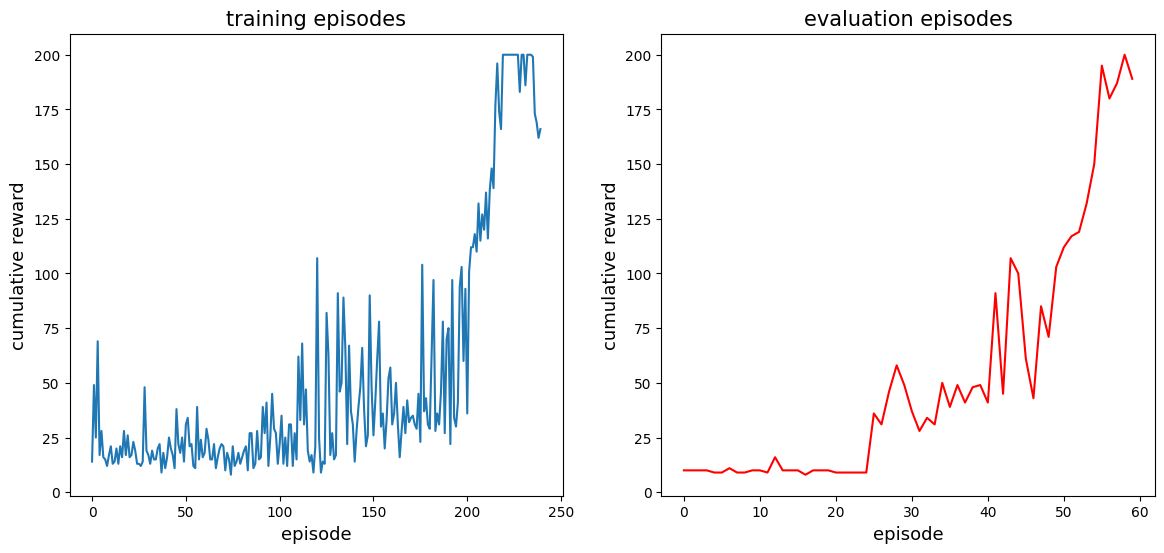

In [7]:
RUNS = 1
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 300
STEPS_PER_EPISODE = 200

env = gym.make("CartPole-v1", render_mode="rgb_array")

##########################################################
# TODO (10 points): 
# Implement the training loop for the online SAC. 
# 1) You need to initialize an agent with the
#    `replay_buffer` set to None. Also, leave the 
#    `use_cql` and `offline` flags to remain False.
# 2) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these 
#    episodes in the end.
# 3) Plot the learning curves.

training_rewards = [list() for i in range(RUNS)]
evaluation_rewards = [list() for i in range(RUNS)]

for run in range(RUNS):
    online_agent = SACAgent(environment=env)
    print(f'Run # {run}')
    print()
    
    for episode in range(EPISODES_PER_RUN):
        # reset the environment to get s0
        state, info = env.reset()

        # test episode
        if episode % (TRAINING_EVALUATION_RATIO + 1) == 0:
            total_reward = 0
            for step in range(STEPS_PER_EPISODE):
                # select an action
                action = online_agent.get_next_action(
                    state=state,
                    evaluation_episode=True
                )
                next_state, reward, terminated, truncated, info = env.step(action)
                done = truncated or terminated
                total_reward += reward
                
                state = next_state

                # If truncated, start a new episode
                if done:
                    state, info = env.reset()
                    break

            evaluation_rewards[run].append(total_reward)
            print(f'(evaluation) episode {episode}, total reward: {total_reward}')

        # Training episode
        else:
            total_reward = 0
            for step in range(STEPS_PER_EPISODE):
                # select an action
                action = online_agent.get_next_action(
                    state=state,
                    evaluation_episode=False
                )
                next_state, reward, terminated, truncated, info = env.step(action)
                done = truncated or terminated
                total_reward += reward

                # train on a single transition
                online_agent.train_on_transition(
                    state=state,
                    discrete_action=action,
                    next_state=next_state,
                    reward=reward,
                    done=done
                )
                state = next_state

                # If truncated, start a new episode
                if done:
                    state, info = env.reset()
                    break
                    
            training_rewards[run].append(total_reward)
            
    print()


training_rewards = np.array(training_rewards).mean(0)
evaluation_rewards = np.array(evaluation_rewards).mean(0)

# Plots        
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(training_rewards)
ax1.set_xlabel('episode', fontsize=13)
ax1.set_ylabel('cumulative reward', fontsize=13)
ax1.set_title('training episodes', fontsize=15)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(evaluation_rewards, color='red')
ax2.set_xlabel('episode', fontsize=13)
ax2.set_ylabel('cumulative reward', fontsize=13)
ax2.set_title('evaluation episodes', fontsize=15);
##########################################################

In [8]:
# Run one test episode and save frames
state, info = env.reset()
online_agent_frames = []

done = False

with torch.no_grad():
    while not done:
        online_agent_frames.append(env.render())
        action = online_agent.get_next_action(
            state,
            evaluation_episode=True
        )
        next_state, reward, terminated, truncated, info = env.step(action)
        done = truncated or terminated
        state = next_state
        
display_frames_as_gif(online_agent_frames)

## Offline SAC training loop (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

Run # 0

Training on offline data ...


  0%|          | 0/200 [00:00<?, ?it/s]

Offline training finished

(evaluation) episode 0, total reward: 8.0
(evaluation) episode 1, total reward: 10.0
(evaluation) episode 2, total reward: 9.0
(evaluation) episode 3, total reward: 9.0
(evaluation) episode 4, total reward: 8.0
(evaluation) episode 5, total reward: 9.0
(evaluation) episode 6, total reward: 10.0
(evaluation) episode 7, total reward: 8.0
(evaluation) episode 8, total reward: 11.0
(evaluation) episode 9, total reward: 10.0
(evaluation) episode 10, total reward: 10.0
(evaluation) episode 11, total reward: 9.0
(evaluation) episode 12, total reward: 10.0
(evaluation) episode 13, total reward: 9.0
(evaluation) episode 14, total reward: 10.0
(evaluation) episode 15, total reward: 8.0
(evaluation) episode 16, total reward: 9.0
(evaluation) episode 17, total reward: 9.0
(evaluation) episode 18, total reward: 10.0
(evaluation) episode 19, total reward: 10.0
(evaluation) episode 20, total reward: 10.0
(evaluation) episode 21, total reward: 9.0
(evaluation) episode 22, to

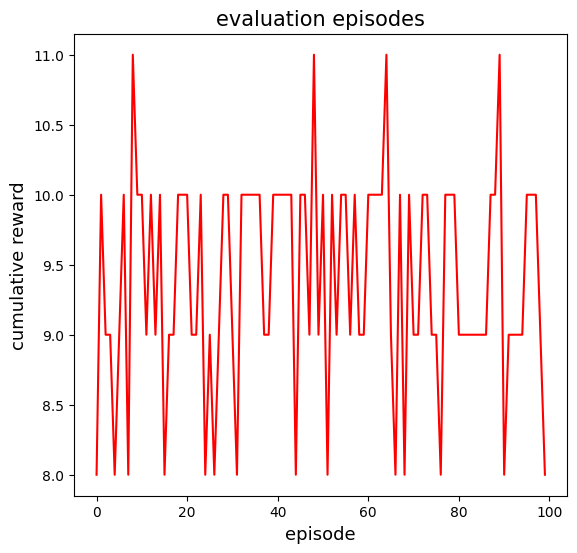

In [10]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1", render_mode="rgb_array")

##########################################################
# TODO (10 points): 
# Implement the training loop for the offline SAC. 
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set 
#     the `offline` flag and leave the `use_cql` flag to 
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these 
#    episodes in the end.

evaluation_rewards = [list() for i in range(RUNS)]

for run in range(RUNS):
    print(f'Run # {run}')
    print()

    offline_agent = SACAgent(
        environment=env,
        replay_buffer=online_agent.replay_buffer,
        offline=True,
        use_cql=False
    )
    
    offline_agent.replay_buffer.set_mirror_indexes()

    print('Training on offline data ...')
    for epoch in tqdm(range(NUM_EPOCHS)):
        replay_buffer_index = 0
        replay_buffer_size = offline_agent.replay_buffer.get_size()
        while replay_buffer_index < replay_buffer_size:
            offline_agent.train_networks(batch_deterministic_start=replay_buffer_index)
            replay_buffer_index += offline_agent.REPLAY_BUFFER_BATCH_SIZE
    print('Offline training finished')
    print()

    # evaluation loop    
    for episode in range(EPISODES_PER_RUN):
        # reset the environment to get s0
        state, info = env.reset()

        # test episode
        total_reward = 0
        for step in range(STEPS_PER_EPISODE):
            # select an action
            action = offline_agent.get_next_action(
                state=state,
                evaluation_episode=True
            )
            next_state, reward, terminated, truncated, info = env.step(action)
            done = truncated or terminated
            total_reward += reward

            state = next_state
            # If truncated, start a new episode
            if done:
                state, info = env.reset()
                break

        evaluation_rewards[run].append(total_reward)
        print(f'(evaluation) episode {episode}, total reward: {total_reward}')
            
    print()


evaluation_rewards = np.array(evaluation_rewards).mean(0)

# Plots        
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(evaluation_rewards, color='red')
ax1.set_xlabel('episode', fontsize=13)
ax1.set_ylabel('cumulative reward', fontsize=13)
ax1.set_title('evaluation episodes', fontsize=15);
##########################################################

In [11]:
# Run one test episode and save frames
state, info = env.reset()
offline_agent_frames = []

done = False

with torch.no_grad():
    while not done:
        offline_agent_frames.append(env.render())
        action = offline_agent.get_next_action(
            state,
            evaluation_episode=True
        )
        next_state, reward, terminated, truncated, info = env.step(action)
        done = truncated or terminated
        state = next_state
        
display_frames_as_gif(offline_agent_frames)

## Conservative SAC training loop (5 points)

Similar to the previous part, you are going to train another offline agent. In this part, you are going to use the conservative version of SAC.

Run # 0

Training on offline data ...


  0%|          | 0/200 [00:00<?, ?it/s]

Offline training finished

(evaluation) episode 0, total reward: 85.0
(evaluation) episode 1, total reward: 107.0
(evaluation) episode 2, total reward: 141.0
(evaluation) episode 3, total reward: 129.0
(evaluation) episode 4, total reward: 88.0
(evaluation) episode 5, total reward: 123.0
(evaluation) episode 6, total reward: 120.0
(evaluation) episode 7, total reward: 175.0
(evaluation) episode 8, total reward: 153.0
(evaluation) episode 9, total reward: 109.0
(evaluation) episode 10, total reward: 117.0
(evaluation) episode 11, total reward: 128.0
(evaluation) episode 12, total reward: 94.0
(evaluation) episode 13, total reward: 103.0
(evaluation) episode 14, total reward: 112.0
(evaluation) episode 15, total reward: 103.0
(evaluation) episode 16, total reward: 87.0
(evaluation) episode 17, total reward: 146.0
(evaluation) episode 18, total reward: 114.0
(evaluation) episode 19, total reward: 120.0
(evaluation) episode 20, total reward: 111.0
(evaluation) episode 21, total reward: 130

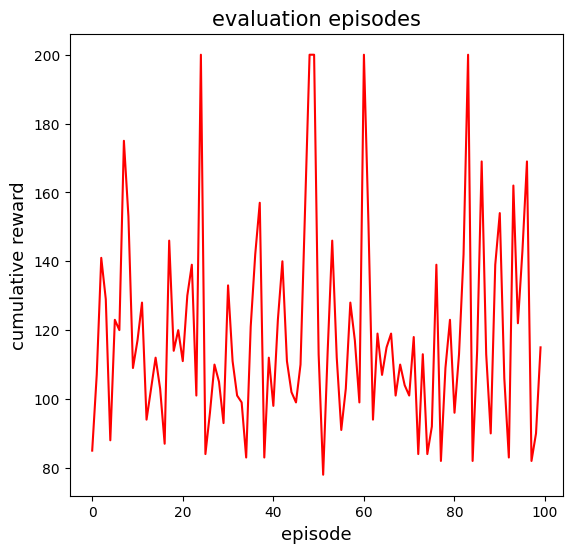

In [9]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1", render_mode="rgb_array")

##########################################################
# TODO (5 points): 
# Implement the training loop for the conservative SAC. 
# 1) You need to initialize an agent with the current
#    `replay_buffer` of the online agent. Set the `offline`
#     and `use_cql` flags.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these 
#    episodes in the end.

evaluation_rewards = [list() for i in range(RUNS)]

for run in range(RUNS):
    print(f'Run # {run}')
    print()

    offline_cql_agent = SACAgent(
        environment=env,
        replay_buffer=online_agent.replay_buffer,
        offline=True,
        use_cql=True
    )
    
    offline_cql_agent.replay_buffer.set_mirror_indexes()

    print('Training on offline data ...')
    for epoch in tqdm(range(NUM_EPOCHS)):
        replay_buffer_index = 0
        replay_buffer_size = offline_cql_agent.replay_buffer.get_size()
        while replay_buffer_index < replay_buffer_size:
            offline_cql_agent.train_networks(batch_deterministic_start=replay_buffer_index)
            replay_buffer_index += offline_cql_agent.REPLAY_BUFFER_BATCH_SIZE
    print('Offline training finished')
    print()

    # evaluation loop    
    for episode in range(EPISODES_PER_RUN):
        # reset the environment to get s0
        state, info = env.reset()

        # test episode
        total_reward = 0
        for step in range(STEPS_PER_EPISODE):
            # select an action
            action = offline_cql_agent.get_next_action(
                state=state,
                evaluation_episode=True
            )
            next_state, reward, terminated, truncated, info = env.step(action)
            done = truncated or terminated
            total_reward += reward

            state = next_state
            # If truncated, start a new episode
            if done:
                state, info = env.reset()
                break

        evaluation_rewards[run].append(total_reward)
        print(f'(evaluation) episode {episode}, total reward: {total_reward}')
            
    print()


evaluation_rewards = np.array(evaluation_rewards).mean(0)

# Plots        
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(evaluation_rewards, color='red')
ax1.set_xlabel('episode', fontsize=13)
ax1.set_ylabel('cumulative reward', fontsize=13)
ax1.set_title('evaluation episodes', fontsize=15);
##########################################################

In [12]:
# Run one test episode and save frames
state, info = env.reset()
offline_cql_agent_frames = []

done = False

with torch.no_grad():
    while not done:
        offline_cql_agent_frames.append(env.render())
        action = offline_cql_agent.get_next_action(
            state,
            evaluation_episode=True
        )
        next_state, reward, terminated, truncated, info = env.step(action)
        done = truncated or terminated
        state = next_state
        
display_frames_as_gif(offline_cql_agent_frames)

## Comparisons (14 points)
Now, analyze your results and justify the trends you see. Then answer the following questions.

❓ What is the reason for the difference between online and offline performance of the agent?
In an online setting, the agent have the chance to interact with the environment and see the results of its actions. But in offline setting, the agent cannot interact with the environment and may have overestimation over the values of the actions that are not present in the dataset. This is not a problem in online setting because the agent can simply try that action once and the real value of it will be revealed. But this is problematic in offline setting as the agent will never know the real value of the unseen data. To mitigate this problem, we use the conservative loss to prevent agent from exploration.

❓ Which one is better: offline SAC or conservative SAC?
Conservative SAC is better because it avoids exploiting the data that are not present in the training set as apposed to offline SAC which makes overestimation on the data not present in the training set. 

❓ What is the effect of `TRADEOFF_FACTOR` in the offline setting? How does changing its value affect the results?
The tradeoff factor controls how much the agent avoids unseen actions. In offline setting (which our agent can't interact with the environment), we use the conservative loss to prevent agent from exploring unseen actions. If tradeoff factor is set to zero, the result will be the same as offline SAC.